<a href="https://colab.research.google.com/github/aldisstar/Taller-MIT/blob/main/Classification_Methods_(Logistic_Regression%2C_Decision_Trees%2C_Random_Forest%2C_Gradient_boosting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classification Methods
####Introduction

In lecture, we talked about how to approach a building a model.
1. Define Problem Objective
2. Explore the Data
3. Start With Simple Algorithms
4. Try and Compare Different Algorithms


We also discussed the following classification algorithms:


1.   Logistic Regression
2.   Decision Trees
3.   Random Forest
4.   Gradient Boosting


In today's session, we will be continuing to use the Kobe dataset and will use the algorithms learned in class today to do so.




##Import Modules

In [ ]:
# ==============================================
# 0. Module imports
# ==============================================


# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed
import multiprocessing

# text mining
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# model evaluation
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

##Import Data

In [ ]:
dataset = pd.read_csv('Kobe data.csv')

#Reviewing the Dataset

Important Features:


1. **action_type** - the type of shot that Kobe took (Jump shot, Driving Layup Shot, etc)
2. **loc_x** - the x coordinate of the shot (side-to-side), where 0 is the middle of the court
3. **loc_y** - The y coordinate of the shot (up & down the court), where 0 is the free throw line
4. **shot_distance** - the shot's distance, in feet, from the basket
5. **shot_zone_basic** - level area of the court the shot was taken from (top level)
6. **shot_zone_area** - the area of the court the shot was taken from (lower level)
7. **shot_type** - "2PT Field Goal" or "3PT Field Goal"
8. **period** - the period of the game, including overtime
9. **minutes_remaining** - the number of minutes remaining in the period, within the period
10. **seconds_remaining** - the number of seconds, within the minutes, within the period, remaining in the period
11. **playoffs** - binary variable indicating whether or not the game was a playoff game
12. **season** - which season the game was played in
13. **game_date**
14. **matchup** - Los Angeles Lakers (LAL) @ or vs. Opponent Team. An "@" symbol indicates an away game, while "vs." indicates a home game.
15. **shot_made_flag** - our dependent variable, did Kobe make the shot (1 = he did)

Note, this dataset does *not* give shots in chronological order. Be sure not to use future data to predict the present (hint)

In [ ]:
# ==============================================
# 2. Data loading and explore
# ==============================================

# load the data as a pandas dataframe
#Get CSV File from here: https://drive.google.com/file/d/1HTNFCuuwnqpzg5zxPXjIl6Z2pFZ8W7p1/view?usp=share_link
KobeDataset = pd.read_csv('Kobe data.csv')
print("Data dimensions:" + str(KobeDataset.shape))

# we will narrow our focus to only the 15 features listed above
KobeDataset = KobeDataset.filter(["action_type", "loc_x", "loc_y","shot_distance", "shot_zone_basic", "shot_zone_area", "shot_type",
                                  "period", "minutes_remaining", "seconds_remaining", "playoffs", "season", "game_date","matchup", "shot_made_flag"])

#Clean Data
FullLength = len(KobeDataset)
KobeDataset = KobeDataset.loc[~pd.isnull(KobeDataset['shot_made_flag'])]
print("Removed", FullLength - len(KobeDataset), "records with null shot_made flag")

print("Filtered Data dimensions:" + str(KobeDataset.shape))
KobeDataset = KobeDataset.loc[~pd.isnull(KobeDataset['shot_made_flag'])]
KobeDataset = KobeDataset.loc[~pd.isnull(KobeDataset['shot_distance'])]


display(KobeDataset.head(10))

Data dimensions:(30697, 31)
Removed 5000 records with null shot_made flag
Filtered Data dimensions:(25697, 15)


,action_type,loc_x,loc_y,shot_distance,shot_zone_basic,shot_zone_area,shot_type,period,minutes_remaining,seconds_remaining,playoffs,season,game_date,matchup,shot_made_flag
1,Jump Shot,-157,0,15.0,Mid-Range,Left Side(L),2PT Field Goal,1,10,22,0,2000-01,10/31/00,LAL @ POR,0.0
2,Jump Shot,-101,135,16.0,Mid-Range,Left Side Center(LC),2PT Field Goal,1,7,45,0,2000-01,10/31/00,LAL @ POR,1.0
3,Jump Shot,138,175,22.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,6,52,0,2000-01,10/31/00,LAL @ POR,0.0
4,Driving Dunk Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,2,6,19,0,2000-01,10/31/00,LAL @ POR,1.0
5,Jump Shot,-145,-11,14.0,Mid-Range,Left Side(L),2PT Field Goal,3,9,32,0,2000-01,10/31/00,LAL @ POR,0.0
6,Layup Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,3,8,52,0,2000-01,10/31/00,LAL @ POR,1.0
8,Jump Shot,-65,108,12.0,In The Paint (Non-RA),Left Side(L),2PT Field Goal,3,6,12,0,2000-01,10/31/00,LAL @ POR,1.0
9,Running Jump Shot,-33,125,12.0,In The Paint (Non-RA),Center(C),2PT Field Goal,3,3,36,0,2000-01,10/31/00,LAL @ POR,0.0
10,Jump Shot,-94,238,25.0,Above the Break 3,Left Side Center(LC),3PT Field Goal,3,1,56,0,2000-01,10/31/00,LAL @ POR,0.0
11,Jump Shot,121,127,17.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,11,0,0,2000-01,11/1/00,LAL vs. UTA,1.0


In [ ]:
# =============================
# 1.1 Train-val-test split
# =============================

train, val = train_test_split(KobeDataset, test_size= 0.25, train_size= 0.75, random_state= 123)
val, test = train_test_split(val, test_size= 0.25, train_size= 0.75, random_state= 123)


### Exercise \#1 Decision Tree

Let's build a simple decision tree!

In [ ]:
# ==========================================
# 1. Decision Trees/CART Model
# ==========================================

from sklearn import tree

# use only numeric variables without any missing values
feat = ["minutes_remaining","shot_distance","loc_x", "loc_y", "seconds_remaining"]
label = "shot_made_flag"

#Create a Decision Tree and fit on training data, then predict on validation data. Hint: function is tree.DecisionTreeClassifier()
cart_default = tree.DecisionTreeClassifier(splitter = 'best', max_depth = 3).fit(train[feat],train[label])

# predict
cart_val = cart_default.predict_proba(val[feat])[:,1]

print(" -- -- -- ")

# Let's check the performance by outputting the OSR^2 (Out of Sample R^2) score.
print("CART performance: " + str(np.round(roc_auc_score(val[label],cart_val), 5)))

 -- -- -- 
CART performance: 0.60314


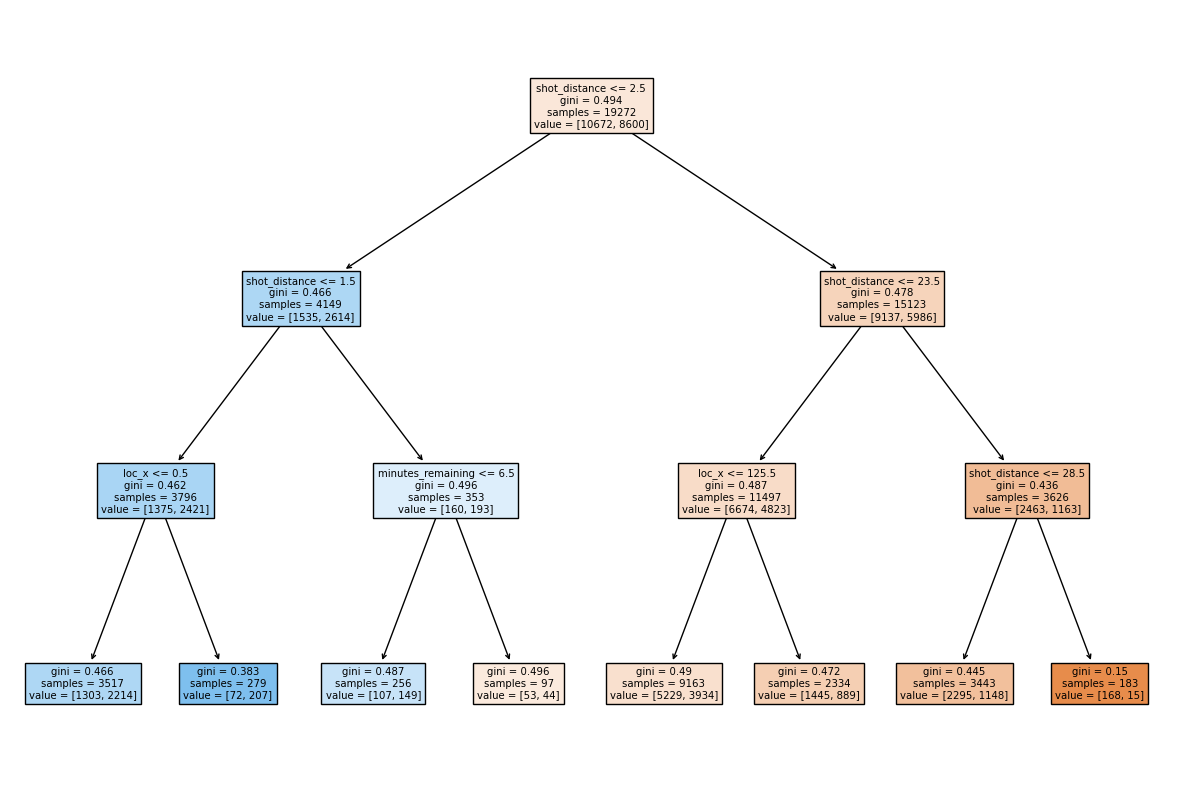

In [ ]:
#Visualize your decision tree with this code:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
tree.plot_tree(cart_default,impurity = True, feature_names=feat,filled=True)
plt.show()

### Exercise \#2 Baseline GBM Model

For this, let's use only numeric features without any missing data to create our models.

**Exercise 2**
Build a Gradient Boosting Model with the given features, and fit on training set


In [ ]:
# ==========================================
# 2. GBM
# ==========================================

# use only numeric variables without any missing values
feat = ["minutes_remaining", "loc_x", "loc_y","shot_distance","seconds_remaining"]
label = "shot_made_flag"

#Create Gradient Boosting model and fit on training data, then predict on validation data
# simple gbm
gbm1 = GradientBoostingClassifier()
gbm1.fit(train[feat], train[label])

# predict on validation data
gbm1_val = pd.Series(gbm1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
#Lets Check on its performance (gbm1_val = the values of the prediction on validation data, substitute with name used)
print("Baseline GBM performance: " + str(np.round(roc_auc_score(val[label], gbm1_val), 5)))

 -- -- -- 
Baseline GBM performance: 0.61181


##Feature Engineering - Understanding variable importance

Let's call back to yesterday to think through what variables might be important. Run the code block below.

In [ ]:
KobeDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25696 entries, 1 to 30696
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   action_type        25696 non-null  object 
 1   loc_x              25696 non-null  int64  
 2   loc_y              25696 non-null  int64  
 3   shot_distance      25696 non-null  float64
 4   shot_zone_basic    25696 non-null  object 
 5   shot_zone_area     25696 non-null  object 
 6   shot_type          25696 non-null  object 
 7   period             25696 non-null  int64  
 8   minutes_remaining  25696 non-null  int64  
 9   seconds_remaining  25696 non-null  int64  
 10  playoffs           25696 non-null  int64  
 11  season             25696 non-null  object 
 12  game_date          25696 non-null  object 
 13  matchup            25696 non-null  object 
 14  shot_made_flag     25696 non-null  float64
dtypes: float64(2), int64(6), object(7)
memory usage: 3.1+ MB


###Exercise \#3 Plot Feature Importance

**Exercise 3**. Which features do we consider the most important in our classification?
Which are the least important?

**Hint:** It might be useful to use the feature_importances attribute

Build a DataFrame with two columns. One with the name of the feature, and a second with the feature importance

Note: "Feature importance" is a metric for how valuable an attribute is in creating the model. It's calculated based on how much a given feature reduces the "impurity" of the trees, as we discussed in class.

In [ ]:
#Answer

gbm_feat_imp = pd.DataFrame({"feat": feat, "imp": np.round(gbm1.feature_importances_,3)})
gbm_feat_imp = gbm_feat_imp.sort_values(by= ["imp"], ascending= False)
print(gbm_feat_imp)

                feat    imp
3      shot_distance  0.660
1              loc_x  0.106
4  seconds_remaining  0.092
2              loc_y  0.088
0  minutes_remaining  0.054


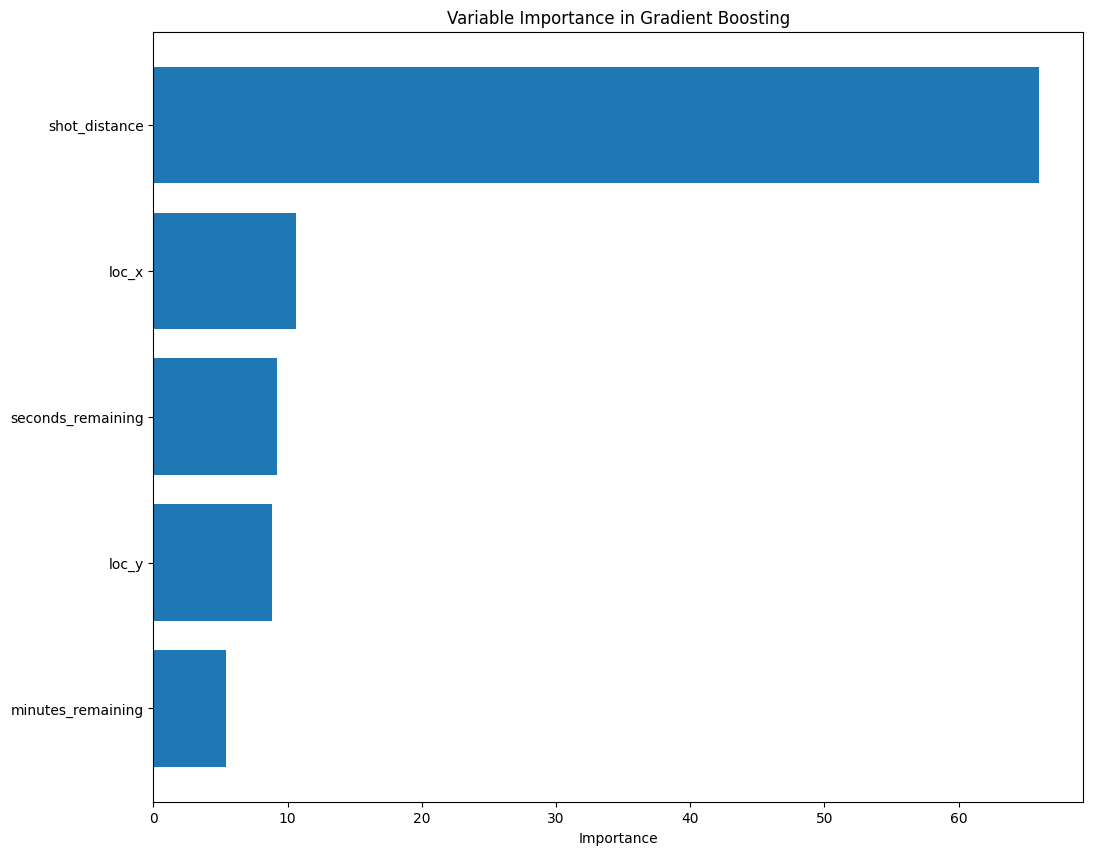

In [ ]:
#lets visualize this (optional)
gbm_feat_imp = gbm_feat_imp.sort_values(by= ["imp"], ascending= True)
pos = np.arange(gbm_feat_imp.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.subplot(1, 1, 1)
plt.barh(pos, gbm_feat_imp.imp.values*100, align='center')
plt.yticks(pos, gbm_feat_imp.feat.values)
plt.xlabel("Importance")
plt.title("Variable Importance in Gradient Boosting")
plt.show()

##Quick Recap

2. We have discussed the following classification algorithms:
    1. Logistic Regression
    2. Random Forests
    2. Boosted Models
    3. Ensemble Learning

3. We will also look at the following:
    1. Extremely Randomized Trees (similar to Random Forest)
    2. Stochastic Gradient Descent (SGD)


##Random Forest and Extremely Randomized Trees

Apart from RF, will also be using the ExtraTrees Algorithm, also known as Extremely Randomized Trees (ERT).

ERT works very similarly to Random Forests, except that ERT randomizes splits (instead of finding optimal one like random forest), thereby adding randomization to the problem. Looking at results, both are very similar, however, ERT is computationally faster.


###Exercise \#4 RF and ERT

For **Exercise 4**, we will build a RF Model and an ERT Model.

In [ ]:

#RF
#Base Features
rf1 = RandomForestClassifier()
rf1.fit(train[feat], train[label])

rf1_val = rf1.predict_proba(val[feat])[:,1]

print("RF Performance (Base Feats): " + str(np.round(roc_auc_score(val[label], rf1_val), 5)))

#ERT
#Base Features
ert1 = ExtraTreesClassifier()
ert1.fit(train[feat], train[label])

# predict on validation data
ert1_val = ert1.predict_proba(val[feat])[:,1]
print("ERT performance (Base Feats): " + str(np.round(roc_auc_score(val[label], ert1_val), 5)))


RF Performance (Base Feats): 0.57517
ERT performance (Base Feats): 0.57487


*
*
*
*
###**STOP HERE**

The following code contains some examples of follow-on techniques or more advanced algorithms that build on the above. This is for your reference only - no need to work through this material, we just wanted you to have some examples of this type of code in case it came in handy in the future!

*
*
*
*

##Ensemble Learning

Now we move on to ensemble leraning, more specifically, stacking. (We have already seen Bagging (RF and ERT) and Boosting (GBM))

Stacking tries to answer the following question: Given multiple machine learning models that can solve a problem with some accuracy, but in different ways, how do you choose which model to use?

In **exercise 6** below, we will look at several ways of "stacking" these models.

###Exercise \#6 Ensemble Learning

In [ ]:
# =============================
# 5. Ensemble Learning
# =============================

# =============================
# 5.1 Ensemble Learning
#     Simple Average
# =============================

#TODO create a simple average ensemble learning method using the results from ERT, RF and Logistic Regression.
#We simply need to find the average of their predicted values (predicted probabilities)
#Note: the 3 models used should have been trained on the same dataset (try using IDF-PCA), so make any necesary changes to the models.
logReg3 = LogisticRegression().fit(train[feat], train[label])
logReg3_val = logReg3.predict_proba(val[feat])[:,1]
print("LogReg performance (Base Feats): " + str(np.round(roc_auc_score(val[label], logReg3_val), 5)))

# simple blend of logistic, ERT, and RF
simple_avg_val = np.mean([logReg3_val, ert1_val, rf1_val], axis= 0)
print("Simple Avg: " + str(np.round(roc_auc_score(val[label], simple_avg_val), 5)))

LogReg performance (Base Feats): 0.60761
Simple Avg: 0.59009


In [ ]:
#Lets Add GBM to our simple average ensemble learning model.

#TO DO: Create GBM Model using IDF-PCA Features and add it to our simple average model

#Answer
gbm3 = GradientBoostingClassifier()
gbm3.fit(train[feat], train[label])

gbm3_val = gbm3.predict_proba(val[feat])[:,1]

print("GBM Performance IDF-PCA: " + str(np.round(roc_auc_score(val[label], gbm3_val), 5)))

#TO DO: Add to simple average ensemble learning
#answer
simple_avg_val = np.mean([logReg3_val, gbm3_val, ert1_val, rf1_val], axis= 0)
print("Simple Avg (Logit, GMB, ERT, RF): " + str(np.round(roc_auc_score(val[label], simple_avg_val), 5)))


GBM Performance IDF-PCA: 0.61184
Simple Avg (Logit, GMB, ERT, RF): 0.59981


In [ ]:
# =============================
# 5.2 Ensemble Learning
#     Weighted Average
# =============================

#Sometimes, you might trust one model a bit more than the others, for this part, we will again
#compute the average of the models, but this time, you should play around with the weights.

#TODO: Lets add the weights ourselves, play around with different weight values and different combinations of models
#Answer - Example (we get better performance)
simple_avg_val = .2*logReg3_val + .8*gbm3_val
print("Weighted Avg (Logit, GMB, ERT, RF): " + str(np.round(roc_auc_score(val[label], simple_avg_val), 5)))

Weighted Avg (Logit, GMB, ERT, RF): 0.61133


####Ensemble Learning - Meta Model

In stacking, a single model is used to learn how to best combine the predictions from the contributing models. Before, the models used were simple and weighted average.

In reality, the architecture of a stacking model involves level-0 models (the individual models we made), and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

Now, we will try using a Logistic Regression Model as our Level-1 Model

In [ ]:
# =============================
# 5.3 Ensemble Learning
#     Meta Model (w/ Logistic)
# =============================

#TO DO: combine the results from our base models and perform a logistic regression on them
#ANSWER (answer should not have x1/SGD results I just added them)
val_ens = pd.DataFrame({"label": val[label], "gbm3": gbm3_val,
                        "logReg3": logReg3_val, "rf2": rf1_val,
                       "ert2": ert1_val})

logReg4_ens = LogisticRegression()
ens_feat = ["gbm3", "logReg3", "rf2", "ert2"]

logReg4_ens.fit(val_ens[ens_feat], val_ens["label"])

# predict on validation data
logReg4_ens_val = logReg4_ens.predict_proba(val_ens[ens_feat])[:,1]

#Lets Check on its performance (logReg1_val = the values of the prediction on validation data, substitute with name used)
print("Logistic Ensemble performance: " + str(np.round(roc_auc_score(val_ens["label"], logReg4_ens_val), 5)))


Logistic Ensemble performance: 0.61373


##Stochastic Gradient Descent

Now let's look at another way of performing some of the ML techniques learned today.

Stochastic Gradient Descent (SGD) offers a simple yet very efficient approach to fitting linear classifiers (and regressors) under convex loss functions such as Logistic Regression.

SGD is an optimization technique, not a ML technique. It simply offers a different, usually more efficient, *way* of solving the model.


###Exercise \#6 SGD ***OPTIONAL***
For **exercise 6**, we will recreate a logistic regression model using SGD. It might be useful to look at the [SGD parameters](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) more closely

In [ ]:
# =============================
# 4.10 SGD on entire dtm
# =============================

# train sgd
sgd1 = SGDClassifier(loss = "log", penalty = "l2")
sgd1.fit(train[feat], train[label])

# predict on validation data
sgd1_val = sgd1.predict_proba(val[feat])[:,1]
print(" -- -- -- ")

# auc score
print("SGD: " + str(np.round(roc_auc_score(val[label], sgd1_val), 5)))

 -- -- -- 
SGD: 0.50672


##Feature Engineering - Text Features

Now lets finish our feature engineering lesson from yesterday by looking at the text features.

Run the code block below.

# Dataset with Text

We will be working with some data from Kaggle - a machine learning competition site with many datasets: https://www.kaggle.com/c/stumbleupon/data?select=train.tsv.

The dataset here contains information about webpages and the labels are whether or not the site is evergreen. An evergreen site is one that is always relevant. A news article from 1998 would not be evergreen, but a chocolate chip cookie recipe would be. The labels were determined by human judgement.

In [ ]:
%%bash
git clone https://github.com/caboonie/gsl-uruguay.git

Cloning into 'gsl-uruguay'...
Updating files: 100% (5869/5869), done.


In [ ]:
dataset_text = pd.read_table("gsl-uruguay/content/w1d2/train.tsv", sep= "\t")

dataset_text = dataset_text.replace("?", np.nan)
dataset_text[["alchemy_category_score", "is_news", "news_front_page"]] = dataset_text[["alchemy_category_score",
                                                                         "is_news", "news_front_page"]].astype(float)

# =============================
# 1.1 Train-val-test split
# =============================

train_text, val_text = train_test_split(dataset_text, test_size= 0.8, train_size= 0.2, random_state= 234)
val_text, test_text = train_test_split(val_text, test_size= 0.5, train_size= 0.5, random_state= 675)


Fill in missing values and categorical data

Notice how categorical data is filled in here

In [ ]:
# =============================
# 3.1.1 Variables with missing
#     values
# =============================


train_text["alchemy_category_score"] = train_text["alchemy_category_score"].fillna(np.mean(train_text["alchemy_category_score"]))
val_text["alchemy_category_score"] = val_text["alchemy_category_score"].fillna(np.mean(val_text["alchemy_category_score"]))
test_text["alchemy_category_score"] = test_text["alchemy_category_score"].fillna(np.mean(test_text["alchemy_category_score"]))

train_text["is_news"] = train_text["is_news"].fillna(0)
train_text["news_front_page"] = train_text["news_front_page"].fillna(2)

# =============================
# 3.1.2 Categorical variables
# =============================

# impute missing values as separate category
train_text["alchemy_category"] = train_text["alchemy_category"].fillna("_M")
val_text["alchemy_category"] = val_text["alchemy_category"].fillna("_M")
test_text["alchemy_category"] = test_text["alchemy_category"].fillna("_M")

# dummy variables for all categories
alch_train = pd.get_dummies(train_text["alchemy_category"], prefix= "al_cat")
alch_val = pd.get_dummies(val_text["alchemy_category"], prefix= "al_cat")
alch_test = pd.get_dummies(test_text["alchemy_category"], prefix= "al_cat")
train_text = train_text.join(alch_train)
val_text = val_text.join(alch_val)
test_text= test_text.join(alch_test)

In [ ]:
# =============================
# 3.1.3 Text features
# =============================

# TF - COUNT
count_dtm = CountVectorizer(min_df= 10,  max_features= 10000, strip_accents= 'unicode',
                            analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2),
                            binary= True)
count_dtm.fit(train_text["boilerplate"])
train_cnt_dtm = count_dtm.transform(train_text["boilerplate"])
val_cnt_dtm = count_dtm.transform(val_text["boilerplate"])
test_cnt_dtm = count_dtm.transform(test_text["boilerplate"])

# TFIDF
idf_dtm = TfidfVectorizer(min_df= 10,  max_features= None, strip_accents= "unicode",
                          analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2),
                          use_idf= 1, smooth_idf= 1, sublinear_tf= 1)
idf_dtm.fit(train_text["boilerplate"])


train_idf_dtm = idf_dtm.transform(train_text["boilerplate"])
val_idf_dtm = idf_dtm.transform(val_text["boilerplate"])
test_idf_dtm = idf_dtm.transform(test_text["boilerplate"])

#how large is the new dataset?
print(" --- ")
print(train_idf_dtm.shape)
print(" --- ")

 --- 
(1479, 9890)
 --- 


##Dimension Reduction and PCA

As seen above, the new dataset created from TFIDFVectorizer is very large and we might benefit from only using a smaller portion of the data. As such, we use Principal Component Analysis to reduce the dimensionality of the data.

Note that while PCA was not covered in lecture today, it can be extremely useful and you should familiarize yourself with it.

For now, run the code below.



In [ ]:
# =============================
# 4. Dimension reduction -- PCA
# =============================

# lets fit with 100 components
rpca = PCA(n_components = 100, random_state = 8795, svd_solver = "randomized")
rpca.fit(train_idf_dtm.toarray())

# tranform dtm
train_idf_dtm_pca = rpca.transform(train_idf_dtm.toarray())
val_idf_dtm_pca = rpca.transform(val_idf_dtm.toarray())
test_idf_dtm_pca = rpca.transform(test_idf_dtm.toarray())
print(" --- ")
print(train_idf_dtm_pca.shape); print(val_idf_dtm_pca.shape); print(test_idf_dtm_pca.shape)
print(" --- ")

 --- 
(1479, 100)
(2958, 100)
(2958, 100)
 --- 


###Exercise \#3 PCA Optimization

How do we know 100 components is the ideal number of components? We don't, so lets try to optimize for the number of components.

In **Exercise 3**, we will create a function that tells us what the optimal number of components for our PCA is. We do this by running  classification model for every number of components we try, and looking at its performance. We can try out the function with the following # of components = \[50, 100, 200\]

In [ ]:
# =============================
# 4.1 PCA Optimization
# =============================
#TO DO: Test your coding skills:
#Create a function that tells us the optimal number of components for PCA based on model performance
#It should take as input: a list specifying different number of components to test,
#a training set, validation set, training_target, validation target, classification model and evaluation metric (roc_auc_score).

#The function output is up to you, but it should tell us what is the optimal number of components to use.
#Try it with the following list: [50, 100, 200] for # of components and find optimal number.

#Answer (you can ignore the classify=True since we only use classification)
def pca_optimization(n_comp, train, val, training_target, validation_target,
                     model, evaluation, classify=True):

    output = pd.DataFrame(columns=['n_comp', 'score'])

    for r in range(0,len(n_comp)):
        rpca = PCA(n_components = n_comp[r], random_state = 8756, svd_solver = "randomized")
        rpca.fit(train.toarray())

        # tranform dtm
        train_pca = rpca.transform(train.toarray())
        val_pca = rpca.transform(val.toarray())
        print(" --- ")
        print('explained variance (first %d components): %.2f'%(n_comp[r], sum(rpca.explained_variance_ratio_)))

        if classify:
            model.fit(train_pca, training_target)
            model_val = model.predict_proba(val_pca)[:,1]
        else:
            model.fit(train_pca, training_target)
            model_val = model.predict(val_pca)
        score = np.round(evaluation(validation_target, model_val), 5)
        data= {"id": n_comp[r],"score": score}
        output = output.append(pd.Series([n_comp[r], score], index=['n_comp','score']), ignore_index=True)

    return output

#we try running a logistic regression model with different amount of components from PCA {50, 100, 200}.
model_lr_text = LogisticRegression(penalty = "l2", C = 1)
pca_optimization(n_comp= [50, 100, 200], train= train_idf_dtm, val= val_idf_dtm,
                 training_target= train_text["label"], validation_target= val_text["label"], model= model_lr_text,
                 evaluation= roc_auc_score, classify= True)


 --- 
explained variance (first 50 components): 0.18
 --- 
explained variance (first 100 components): 0.26
 --- 
explained variance (first 200 components): 0.37


,n_comp,score
0,50.0,0.86540
1,100.0,0.86542
2,200.0,0.86591


In [ ]:
##It seems like 100 components is the optimal after all!

#Now lets join base features with tfidf-pca features
#again the base features
feat_text = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4",
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks",
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score",
        "al_cat__M", "al_cat_arts_entertainment", "al_cat_business", "al_cat_computer_internet",
        "al_cat_culture_politics", "al_cat_gaming", "al_cat_health", "al_cat_law_crime", "al_cat_recreation",
        "al_cat_religion", "al_cat_science_technology", "al_cat_sports"]

#TO DO: join the TFIDF-PCA features with the base features in a single dataframe for train, val and test
#ANSWER
train_text_combine = train_text[feat_text].join(pd.DataFrame(train_idf_dtm_pca, index= train_text.index))
val_text_combine = val_text[feat_text].join(pd.DataFrame(val_idf_dtm_pca, index= val_text.index))
test_text_combine = test_text[feat_text].join(pd.DataFrame(test_idf_dtm_pca, index= test_text.index))

First lets make them using the base features (train) and then lets add on the PCA omponents. Remember we already combined them in train_combine

In [ ]:

#ANSWER

#LR
logReg3 = LogisticRegression() #vary penalty = {'l2', 'none'} and C = {<<1, 1, >1, >>1}
logReg3.fit(train_idf_dtm, train_text["label"]) #also use train_idf_dtm_pca

# predict on validation data
logReg3_val = logReg3.predict_proba(val_idf_dtm)[:,1]
print(" -- -- -- ")

# auc score
print("Logistic performance: " + str(np.round(roc_auc_score(val_text["label"], logReg3_val), 5)))
print(" -- -- -- ")

#GB
gbm3 = GradientBoostingClassifier() #use different learning rates and n_stimators
gbm3.fit(train_idf_dtm, train_text["label"])

gbm3_val = logReg3.predict_proba(val_idf_dtm)[:,1]

#auc score:
print("GB Logistic performance: " + str(np.round(roc_auc_score(val_text["label"], gbm3_val), 5)))
print(" -- -- -- ")

#RF
rf2 = RandomForestClassifier()
rf2.fit(train_idf_dtm_pca, train_text["label"])

rf2_val = rf2.predict_proba(val_idf_dtm_pca)[:,1]

print("RF Performance IDF-PCA: " + str(np.round(roc_auc_score(val_text['label'], rf2_val), 5)))
print(" -- -- -- ")

#ERT
ert2 = ExtraTreesClassifier()
ert2.fit(train_idf_dtm_pca, train_text['label'])

ert2_val = ert2.predict_proba(val_idf_dtm_pca)[:,1]

# auc score
print("ERT performance IDF-PCA: " + str(np.round(roc_auc_score(val_text["label"], ert2_val), 5)))


 -- -- -- 
Logistic performance: 0.86507
 -- -- -- 
GB Logistic performance: 0.86507
 -- -- -- 
RF Performance IDF-PCA: 0.85438
 -- -- -- 
ERT performance IDF-PCA: 0.85436


In [ ]:
#Tcombine the results from our base models and perform a logistic regression on them
val_ens = pd.DataFrame({"label": val_text["label"], "gbm3": gbm3_val,
                        "logReg3": logReg3_val, "rf2": rf2_val,
                       "ert2": ert2_val})

logReg4_ens = LogisticRegression()
ens_feat = ["gbm3", "logReg3", "rf2", "ert2"]

logReg4_ens.fit(val_ens[ens_feat], val_ens["label"])

# predict on validation data
logReg4_ens_val = logReg4_ens.predict_proba(val_ens[ens_feat])[:,1]

#Lets Check on its performance (logReg1_val = the values of the prediction on validation data, substitute with name used)
print("Logistic Ensemble performance: " + str(np.round(roc_auc_score(val_ens["label"], logReg4_ens_val), 5)))


Logistic Ensemble performance: 0.8654
